In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 -4*x + 5


In [3]:
f(3.0)

20.0

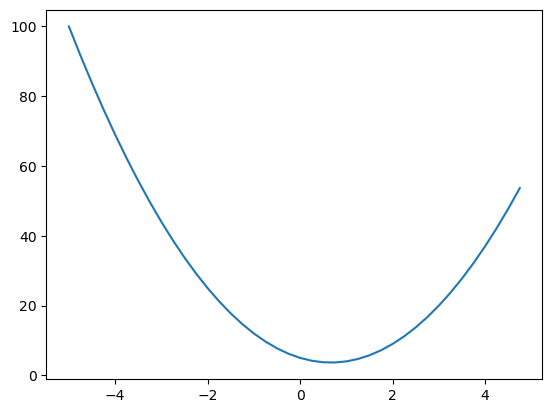

In [4]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
# 간단한 미분의 구현 (미분의 정의를 이용)
h = 0.00000000001
x = 2/3
(f(x + h) - f(x)) / h

0.0

In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

## a의 변화량에 따른 값의 변화
d1 = a*b +c
a += h 
d2 = a*b +c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [22]:
## repr는  Representation의 약자로 
## _children 연산과정을 기억하기 위해 사용
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other),'+')
        
        def _backward():
            self.grad += 1.0 *  out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
            
        return out 
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other),'*')
        
        def _backward():
            self.grad += other.data *  out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self*other**-1
    
    def __pow__(self, other):
        assert isinstance(other,(int,float)),"only support int or float"
        out = Value(self.data**other, (self, ),f'**{other}')
        
        def _backward():
            self.grad += other * self.data**(other-1) * out.grad
        out._backward = _backward
        
        return out 
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ),'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out 
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) -1)/(math.exp(2*x) +1)
        out = Value(t, (self, ),'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out 
    
    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [23]:
a = Value(2.0)
b = Value(4.0)
b - a

Value(data=2.0)

In [24]:
from graphviz import Digraph

def trance(root):
    nodes, edges = set(), list()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.append((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'}) ##왼쪽에서 오른쪽으로
    
    nodes, edges = trance(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(uid, label="%s | data %.4f | grad %.4f" % (n.label,n.data,n.grad), shape ='recod')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2))+n2._op)
    
    return dot

In [28]:
# input x1, x2
x1 = Value(1.0, label='x1')
x2 = Value(0.0, label='x2')

# weight w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.881373587019432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

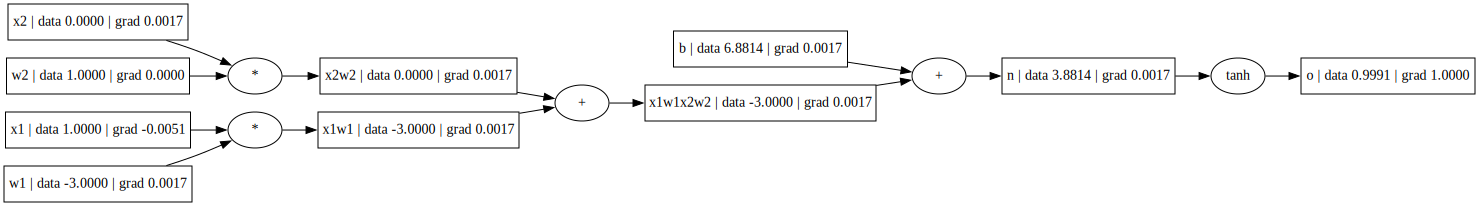

In [29]:
draw_dot(o)

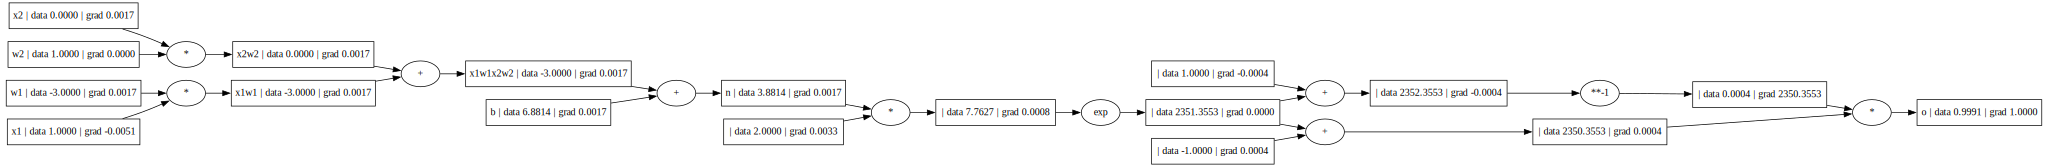

In [30]:
# input x1, x2
x1 = Value(1.0, label='x1')
x2 = Value(0.0, label='x2')

# weight w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.881373587019432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
#------

e = (2*n).exp()
o = (e - 1) / ( e + 1)

#--------

o.label = 'o'
o.backward()
draw_dot(o)